In [1]:
import numpy as np
from scipy import stats
import torchvision
import torch
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader
import multiprocessing
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

MEAN, STD = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)  
    ])

In [52]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


## Finetune on cifar10 to get representation

In [79]:
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

/home/viet/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/viet/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
batch_size = 64
learning_rate=5e-5
epochs = 100

In [59]:
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=multiprocessing.cpu_count())
testloader = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=multiprocessing.cpu_count())

In [60]:
optimizer = optim.AdamW(resnet18.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [62]:
patience = 0
best = 0
for epoch in range(epochs):
    model.train()
    for batch_idx, (imgs, labels) in enumerate(tqdm(trainloader)):
        imgs, labels = imgs.cuda(), labels.cuda()
        output = model(imgs)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    count = 0
    acc = 0 
    with torch.no_grad():
        for imgs, labels in tqdm(testloader):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = torch.argmax(output, 1)
            acc += torch.sum(preds == labels)
            count += len(labels)
    acc = (acc/count).item()
    if acc > best:
        best = acc
        patience = 0
    else:
        patience += 1
    print(acc)
    if patience > 5:
        print(best)
        break

 48%|████▊     | 375/782 [00:02<00:02, 141.49it/s]


KeyboardInterrupt: 

In [ ]:
rep = torch.nn.Sequential(*list(model.children())[:-1])

In [ ]:
rep

In [ ]:
torch.save(rep.state_dict(), 'resnet18_cifar10.pth')

In [84]:
def get_rep(model, dataset):
    model = model.cuda()
    model.eval()
    new_data = np.zeros((len(dataset), 512))
    i = 0
    for features, label in tqdm(dataset):
        features = features.unsqueeze(0).cuda()
        rep = model(features)
        rep = torch.flatten(rep)
        new_data[i] = rep.cpu().detach().numpy()
        i += 1
    return new_data

In [ ]:
x = get_rep(rep, train)

In [ ]:
x_ = get_rep(rep, test)

In [ ]:
with open('data/cifar10_x_train.npy', 'wb') as f:
    np.save(f, x)
with open('data/cifar10_x_test.npy', 'wb') as f:
    np.save(f, x_)
with open('data/cifar10_y_train.npy', 'wb') as f:
    np.save(f, np.array(train.targets))
with open('data/cifar10_y_test.npy', 'wb') as f:
    np.save(f, np.array(test.targets))

## CIFAR-10.1

In [92]:
# load representation
model = torchvision.models.resnet18()
model = torch.nn.Sequential(*list(model.children())[:-1])
model.load_state_dict(torch.load('resnet18_cifar10.pth'))
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [93]:
with open('data/cifar10.1_v6_data.npy', 'rb') as f:
    cifar101_x_test = np.load(f)
with open('data/cifar10.1_v6_labels.npy', 'rb') as f:
    cifar101_y_test = np.load(f)
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)  
    ])

In [94]:
from torch.utils.data import Dataset, DataLoader
class Cifar101(Dataset):
    def __init__(self, images, labels, transform=None):
        self.data = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]
    

In [95]:
dataset = Cifar101(cifar101_x_test, cifar101_y_test, transform=transform)

In [99]:
cifar101_512 = get_rep(model, dataset)

100%|██████████| 2000/2000 [00:01<00:00, 1047.07it/s]


In [101]:
with open('data/cifar101_x_test.npy', 'wb') as f:
    np.save(f, cifar101_512)

### Load cifars

In [6]:
def load_cifar10_512():
    with open('data/cifar10_x_train.npy', 'rb') as f:
        x_train = np.load(f)
    with open('data/cifar10_x_test.npy', 'rb') as f:
        x_test = np.load(f)
    with open('data/cifar10_y_train.npy', 'rb') as f:
        y_train = np.load(f)
    with open('data/cifar10_y_test.npy', 'rb') as f:
        y_test = np.load(f)
    return x_train, x_test, y_train, y_test

In [7]:
def load_cifar101_512():
    with open('data/cifar101_x_test.npy', 'rb') as f:
        x_test = np.load(f)
    with open('data/cifar10.1_v6_labels.npy', 'rb') as f:
        y_test = np.load(f)
    return x_test, y_test

In [8]:
x_train, x_val, y_train, y_val = load_cifar10_512()
x_test, y_test = load_cifar101_512()

(50000, 512)

### Shuffle data

In [8]:
xy_test = np.concatenate([x_test, np.expand_dims(y_test, axis=1)], axis=1)
np.random.shuffle(xy_test)
x_test, y_test = xy_test[:, :512], xy_test[:,512:]

In [9]:
x_test.shape, y_test.shape

((2000, 512), (2000, 1))

## H-Divergence

In [163]:
import numpy as np
from sklearn.decomposition import PCA


def load_cifar10_512():
    with open('data/cifar10_x_train.npy', 'rb') as f:
        x_train = np.load(f)
    #with open('baselines/data/cifar10_x_test.npy', 'rb') as f:
    #    x_test = np.load(f)
    with open('data/cifar10_y_train.npy', 'rb') as f:
        y_train = np.load(f)
    #with open('baselines/data/cifar10_y_test.npy', 'rb') as f:
    #    y_test = np.load(f)
    return x_train, y_train

def load_cifar101_512():
    with open('data/cifar101_x_test.npy', 'rb') as f:
        x_test = np.load(f)
    with open('data/cifar10.1_v6_labels.npy', 'rb') as f:
        y_test = np.load(f)
    return x_test, y_test

def load_and_process_cifar(n_components=10):
    # load datasets -------------------------------
    x_train, y_train = load_cifar10_512()
    x_test, y_test = load_cifar101_512()
    
    xy_train = np.concatenate([x_train, np.expand_dims(y_train, axis=1)], axis=1)
    np.random.shuffle(xy_train)
    x_train, y_train = xy_train[:, :512], xy_train[:,512:]
    
    xy_test = np.concatenate([x_test, np.expand_dims(y_test, axis=1)], axis=1)
    np.random.shuffle(xy_test)
    x_test, y_test = xy_test[:, :512], xy_test[:,512:]
    # PCA -----------------------------------------
    pca = PCA(n_components=n_components)
    pca.fit(x_train)
    x_train_pca, x_test_pca = pca.transform(x_train), pca.transform(x_test)
    print('PCA explained variance ratio: ', sum(pca.explained_variance_ratio_))
    return x_train_pca, x_test_pca, y_train, y_test
    

#### PCA

In [164]:
from sklearn.decomposition import PCA
x_train, x_test, y_train, y_test = load_and_process_cifar(n_components=20)

0.8065869583259311


In [161]:
from divergence import Divergence, permutation_test
hdiv = Divergence('kl')
MAX_SIZE=5

In [162]:
flag, distr, est = permutation_test(hdiv, X=x_train, Y=x_test, perms=500, enable_tqdm=True, max_size=MAX_SIZE)

100%|██████████| 500/500 [00:00<00:00, 5825.91it/s]


0


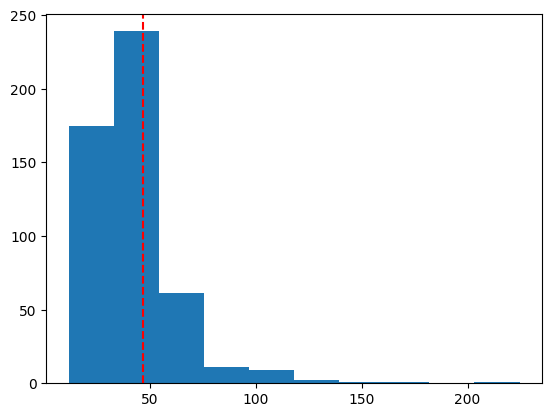

In [147]:
import matplotlib.pyplot as plt
plt.hist(distr)
plt.axvline(x=est, color='r', linestyle='--')
print(flag)

In [154]:
flags = 0
for i in tqdm(range(100)):
    flag, distr, est = permutation_test(hdiv, X=x_train, Y=x_test, perms=500, enable_tqdm=False, max_size=MAX_SIZE)
    flags += flag
flags /= 100
flags

100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


0.18

In [5]:
class KL_Divergence:
    '''
    Given two datasets, fit 2 gaussians on each of them.
    Then, compute the kl-divergence between them depending on the mode.
    '''
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
    
    def get_distance(self, X, Y):
        X, Y = X.T, Y.T
        kernel_X = stats.gaussian_kde(X, self.bandwidth)
        kernel_Y = stats.gaussian_kde(Y, self.bandwidth)
        prob_p = kernel_X.evaluate(X)
        logprob_p = kernel_X.logpdf(X)
        logprob_q = kernel_Y.logpdf(X)
        
        kl = np.mean(np.multiply(prob_p, logprob_p - logprob_q))
        
        return kl

### Test .py file

In [134]:
import numpy as np
from divergence import Divergence, permutation_test
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


In [45]:
distance = Divergence('h')
X = np.random.normal(0,1, (50000, 10))
Y = np.random.normal(0.5,1, (30, 10))

In [ ]:
flag, distr, est = permutation_test(distance, X, Y, enable_tqdm=True)

0


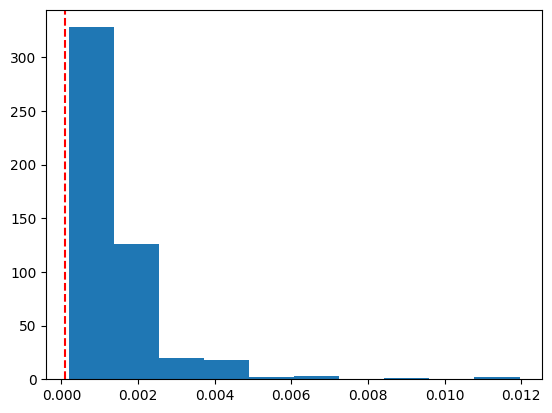

In [48]:
plt.hist(distr)
plt.axvline(x=est, color='r', linestyle='--')
print(flag)

## UCI Dataset debug

In [1]:
from scipy.io import loadmat
import numpy as np
from divergence import Divergence, permutation_test, _bootstrap
from uci_loader import load_and_process_uci
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
%matplotlib inline
uci_dict = loadmat('../data/sample_data/uci_heart_processed.mat')

In [49]:
distance = Divergence('h')
# load data
x_train, x_test, y_train, y_test = load_and_process_uci('../data/sample_data/uci_heart_processed.mat')

In [50]:
def normalize(data, mean, std):
    return (data - mean) / std

In [51]:
# normalize data
train_mean, train_std = np.mean(x_train, axis=0), np.std(x_train, axis=0)
x_train = normalize(x_train, train_mean, train_std)
x_test = normalize(x_test, train_mean, train_std)

In [52]:
pca = PCA(n_components=9)
pca.fit(x_train)
x_train, x_test = pca.transform(x_train), pca.transform(x_test)

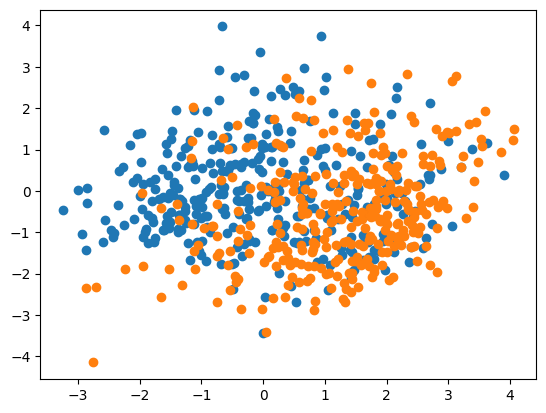

In [53]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.scatter(x_test[:, 0], x_test[:, 1])

In [57]:
MAX_SIZE=100

In [58]:
flag, distr, est = permutation_test(distance, X=x_train, Y=x_test[:MAX_SIZE], enable_tqdm=True, max_size=MAX_SIZE)

100%|██████████| 500/500 [00:00<00:00, 662.36it/s]

1


1


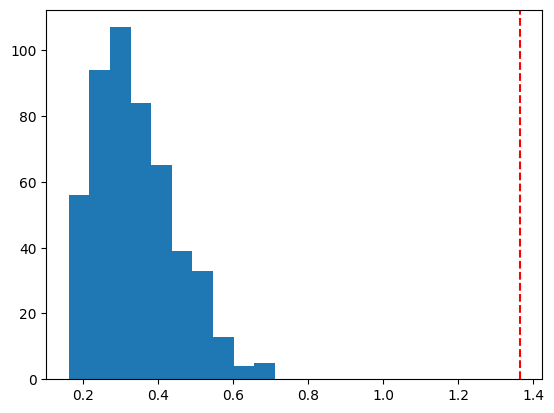

In [59]:
plt.hist(distr)
plt.axvline(x=est, color='r', linestyle='--')
print(flag)

In [104]:
distr

[0.05868006494841982,
 0.05634054264678756,
 0.07686247002408297,
 0.09050158547751863,
 0.06392156271816685,
 0.07370496210679711,
 0.06710078153121213,
 0.09167060237461211,
 0.060412730890125665,
 0.07281906795569881,
 0.08800304703771733,
 0.08325963788886348,
 0.0895980259267235,
 0.0977774969437144,
 0.07969102261527272,
 0.07616256671683708,
 0.03849139725473716,
 0.0892845658597885,
 0.0840394954870467,
 0.059997611159519515,
 0.06469010827626853,
 0.0847397843173141,
 0.08714113715954941,
 0.05738304290470708,
 0.1041936602467457,
 0.05620876645096118,
 0.0751256902840236,
 0.06262409903275401,
 0.05649498279627174,
 0.05865647179068212,
 0.09670575560532768,
 0.06185112383096403,
 0.06625683372315638,
 0.08024462296489165,
 0.053457381744685506,
 0.10416501826026714,
 0.08127091254230301,
 0.09705487826470272,
 0.06246001060969242,
 0.062334627828184,
 0.05520121080493556,
 0.07002239699714075,
 0.05234839887597609,
 0.07332873433403098,
 0.11680058806880478,
 0.0749378927265

### KL-divergence debugging

In [3]:
import numpy as np
import pickle
from scipy import stats
import sys
import argparse
import os

from tqdm import tqdm

In [56]:
def get_kde_estimates(bandwidth, data) :
	# kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
	data = data.T
	kernel = stats.gaussian_kde(data, bandwidth)
	return kernel.evaluate(data)

def get_kde_estimates_log(bandwidth, data) :
	# kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
	data = data.T
	kernel = stats.gaussian_kde(data, bandwidth)
	return kernel.logpdf(data)

In [58]:

def in_top_k(scores, k):
	indices = np.argsort(scores)[::-1]
	pos = np.where(indices==0)[0][0]
	return pos <= k

def evaluate(dataX, dataY, max_data_size=100, bandwidth='scott'):
	scores = []
	idx1 = np.random.choice(len(dataX), max_data_size, replace=False)
	idx2 = np.random.choice(len(dataY), max_data_size, replace=False)

	data1 = dataX[idx1]
	data2 = dataY[idx2]
	for rep in range(100):

		if rep != 0:
			data_all = np.concatenate([data1, data2], axis=0)
			data_all = data_all[np.random.permutation(range(data_all.shape[0]))]
			data1 = data_all[:max_data_size]
			data2 = data_all[max_data_size:]
		datam = np.concatenate([data1[:max_data_size//2], data2[:max_data_size//2]], axis=0)
		
		logprob_1 = get_kde_estimates(bandwidth, data1)
		logprob_2 = get_kde_estimates(bandwidth, data2)
		logprob_m = get_kde_estimates(bandwidth, datam)

		vdiv = np.mean(-logprob_m) - min(np.mean(-logprob_1), np.mean(-logprob_2))
		scores.append(vdiv)

	return in_top_k(scores, k=5), scores

def evaluate_log(dataX, dataY, max_data_size=100, bandwidth='scott'):
	scores = []
	idx1 = np.random.choice(len(dataX), max_data_size, replace=False)
	idx2 = np.random.choice(len(dataY), max_data_size, replace=False)

	data1 = dataX[idx1]
	data2 = dataY[idx2]
	for rep in range(100):

		if rep != 0:
			data_all = np.concatenate([data1, data2], axis=0)
			data_all = data_all[np.random.permutation(range(data_all.shape[0]))]
			data1 = data_all[:max_data_size]
			data2 = data_all[max_data_size:]
		datam = np.concatenate([data1[:max_data_size//2], data2[:max_data_size//2]], axis=0)
		
		logprob_1 = get_kde_estimates_log(bandwidth, data1)
		logprob_2 = get_kde_estimates_log(bandwidth, data2)
		logprob_m = get_kde_estimates_log(bandwidth, datam)

		vdiv = np.mean(-logprob_m) - min(np.mean(-logprob_1), np.mean(-logprob_2))
		scores.append(vdiv)

	return in_top_k(scores, k=5), scores

In [53]:
x = np.random.normal(0,1, (1000, 10))
y = np.random.normal(0.5,1, (1000, 10))

In [59]:
normalspace, normalspacestd = [], []
logspace, logspacestd = [], []

In [61]:
for i in tqdm(range(10)):
    x = np.random.normal(0,1, (1000,10))
    y = np.random.normal(i/10, 1, (1000,10))
    tpr, tprlog = [], []
    for j in range(100):
        tpr.append(evaluate(x,y,max_data_size=100)[0])
        tprlog.append(evaluate_log(x,y,max_data_size=100)[0])
    normalspace.append(np.mean(tpr))
    normalspacestd.append(np.std(tpr))
    logspace.append(np.mean(tprlog))
    logspacestd.append(np.std(tprlog))
    

100%|██████████| 10/10 [02:06<00:00, 12.66s/it]


In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

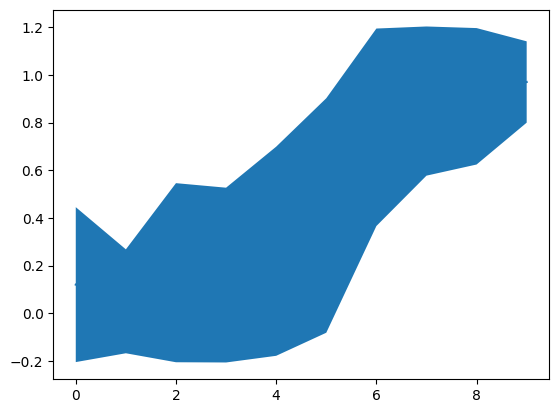

In [67]:
x = np.arange(10)
normalspace, normalspacestd = np.array(normalspace), np.array(normalspacestd)
logspace, logspacestd = np.array(logspace), np.array(logspacestd)


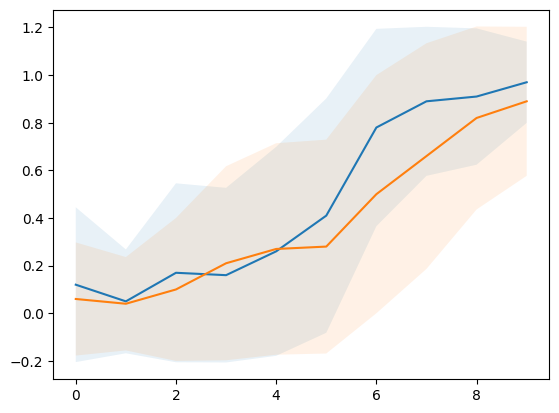

In [69]:
plt.plot(x, normalspace)
plt.fill_between(x,normalspace-normalspacestd, normalspace+normalspacestd, alpha=0.1)
plt.plot(x, logspace)
plt.fill_between(x,logspace-logspacestd, logspace+logspacestd, alpha=0.1)

